In [15]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

# Task 1

In [16]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [17]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [18]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below:

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [19]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [20]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [21]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 dense_5 (Dense)             (None, 256)                  200960    ['input_3[0][0]']             
                                                                                                  
 dense_6 (Dense)             (None, 256)                  65792     ['dense_5[0][0]']             
                                                                                                  
 z_mean (Dense)              (None, 10)                   2570      ['dense_6[0][0]']             
                                                                                            

In [22]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [23]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_7 (Dense)             (None, 256)               2816      
                                                                 
 dense_8 (Dense)             (None, 256)               65792     
                                                                 
 dense_9 (Dense)             (None, 784)               201488    
                                                                 
Total params: 270096 (1.03 MB)
Trainable params: 270096 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## e)

In [24]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}

In [25]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 13s 24ms/step - loss: 226.6198
Epoch 2/10
469/469 [==============================] - 9s 20ms/step - loss: 140.4045
Epoch 3/10
469/469 [==============================] - 8s 18ms/step - loss: 126.0774
Epoch 4/10
469/469 [==============================] - 10s 21ms/step - loss: 120.0568
Epoch 5/10
469/469 [==============================] - 10s 21ms/step - loss: 116.3610
Epoch 6/10
469/469 [==============================] - 8s 18ms/step - loss: 114.4127
Epoch 7/10
469/469 [==============================] - 10s 21ms/step - loss: 112.4477
Epoch 8/10
469/469 [==============================] - 9s 20ms/step - loss: 111.2690
Epoch 9/10
469/469 [==============================] - 14s 31ms/step - loss: 110.1386
Epoch 10/10
469/469 [==============================] - 17s 37ms/step - loss: 109.3211


## f)

In [47]:
# representation in the latent space of observations from test ds
z_test_pred = vae.encoder.predict(x_test)# encoder predictions

313/313 [==============================] - 1s 3ms/step


In [48]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = vae.decoder.predict(z_test_pred[2]) # decoder predictions - we take a vector from the latent space and transform it to be again a picture

313/313 [==============================] - 1s 2ms/step


In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

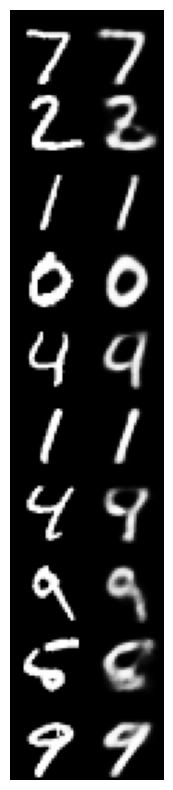

In [50]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [56]:
# use z_test_pred

In [60]:
from sklearn.manifold import TSNE

In [61]:
tsne = TSNE(n_components=2)

In [63]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[2])

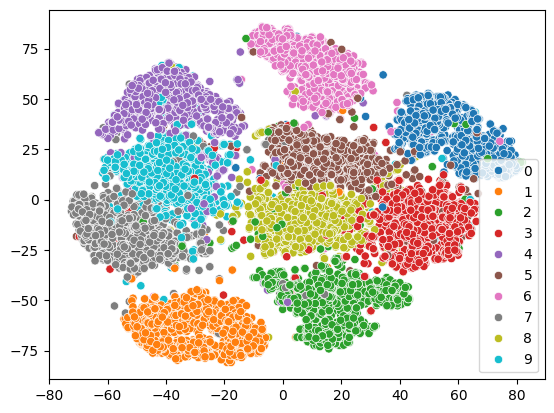

In [64]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

## h)

1/1 [==============================] - 0s 27ms/step


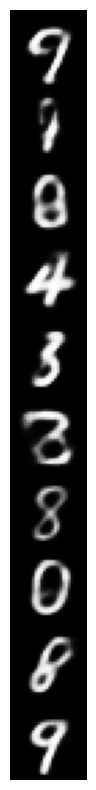

In [80]:
z_new = np.random.randn(10, 10)
new_imgs = vae.decoder.predict(z_new)

fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size))
for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = new_imgs[i, :].reshape(digit_size, digit_size)
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()

# Task 2

In [109]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):
    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

In [110]:
latent_dim = 10

encoder_inputs = keras.Input(shape=(original_dim + 1))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 785)]                0         []                            
                                                                                                  
 dense_25 (Dense)            (None, 256)                  201216    ['input_11[0][0]']            
                                                                                                  
 dense_26 (Dense)            (None, 256)                  65792     ['dense_25[0][0]']            
                                                                                                  
 z_mean (Dense)              (None, 10)                   2570      ['dense_26[0][0]']            
                                                                                            

In [111]:
latent_inputs = keras.Input(shape=(latent_dim + 1,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 11)]              0         
                                                                 
 dense_27 (Dense)            (None, 256)               3072      
                                                                 
 dense_28 (Dense)            (None, 256)               65792     
                                                                 
 dense_29 (Dense)            (None, 784)               201488    
                                                                 
Total params: 270352 (1.03 MB)
Trainable params: 270352 (1.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [116]:
class cVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
      c = tf.cast(data[:, -1], float)
      with tf.GradientTape() as tape:
          z_mean, z_log_var, z = self.encoder(data)
          z = tf.concat([z, c[:, None]], 1)
          reconstruction = self.decoder(z)
          total_loss = -elbo_vae(data[:, :-1], reconstruction, z_mean, z_log_var)

      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)

      return {"loss": self.total_loss_tracker.result()}

In [117]:
cvae = cVAE(encoder, decoder)
cvae.compile(optimizer=keras.optimizers.Adam())
cvae.fit(tf.concat([x_train, y_train[:, None]], 1), epochs=10, batch_size=128)

Epoch 1/10
469/469 [==============================] - 12s 21ms/step - loss: 219.5715
Epoch 2/10
469/469 [==============================] - 9s 19ms/step - loss: 139.7308
Epoch 3/10
469/469 [==============================] - 10s 22ms/step - loss: 126.7719
Epoch 4/10
469/469 [==============================] - 10s 21ms/step - loss: 120.9482
Epoch 5/10
469/469 [==============================] - 9s 19ms/step - loss: 117.5859
Epoch 6/10
469/469 [==============================] - 10s 20ms/step - loss: 115.0614
Epoch 7/10
469/469 [==============================] - 10s 21ms/step - loss: 113.1538
Epoch 8/10
469/469 [==============================] - 10s 20ms/step - loss: 111.3096
Epoch 9/10
469/469 [==============================] - 8s 18ms/step - loss: 110.3796
Epoch 10/10
469/469 [==============================] - 9s 20ms/step - loss: 109.1103


f)

In [133]:
# cond = np.ones_like(x_test[:, 0][:, None]) * 5 #
cond = y_test[:, None]
z_test_pred_c = cvae.encoder.predict(tf.concat([x_test, cond], 1))

313/313 [==============================] - 2s 7ms/step


In [134]:
test_pred_c = cvae.decoder.predict(tf.concat([z_test_pred_c[2], cond], 1))

313/313 [==============================] - 1s 3ms/step


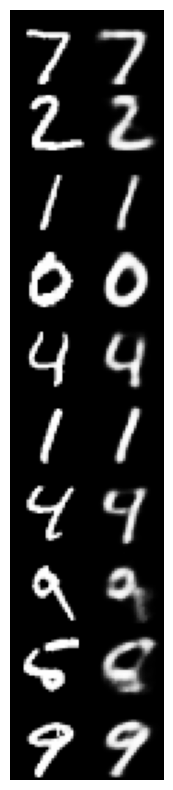

In [135]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred_c

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)

plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


g)

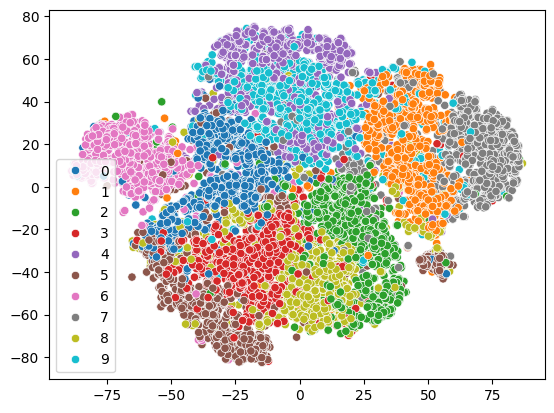

In [142]:
tsne = TSNE(n_components=2)
# tsne_inp = tf.concat([z_test_pred_c[2], cond], 1)
tsne_inp = z_test_pred_c[2]
z_test_pred_tsne_c = tsne.fit_transform(tsne_inp)
N=10000
sns.scatterplot(x=z_test_pred_tsne_c[:N,0], y=z_test_pred_tsne_c[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

h)

1/1 [==============================] - 0s 47ms/step


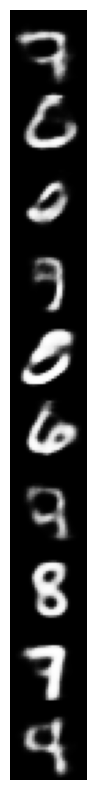

[[3]
 [2]
 [8]
 [4]
 [1]
 [9]
 [4]
 [7]
 [9]
 [3]]


In [143]:
z_new = np.random.randn(10, 10)
c_new = np.random.randint(0, 10, size = (10, 1))
new_imgs = cvae.decoder.predict(tf.concat([z_new, c_new], 1))

fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size))
for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = new_imgs[i, :].reshape(digit_size, digit_size)
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()
print(c_new)